In [2]:
import numpy as np
IMAGE_SIZE = 784
IMAGE_ROWS = 28
IMAGE_COLS = 28
IMAGE_CHANNELS = 1

from bigdl.dataset import mnist
from zoo.pipeline.api.keras.layers import *
from zoo.pipeline.api.keras.models import Model
from zoo.pipeline.api.keras.utils import *
import zoo.pipeline.api.autograd as Z

def get_mnist(sc, mnist_path):
    (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
    train_images = np.reshape(train_images, (60000, 1, 28, 28))
    rdd_train_images = sc.parallelize(train_images)

    rdd_train_sample = rdd_train_images.map(lambda img:
                                            Sample.from_ndarray(
                                                (img > 128) * 1.0,
                                                [(img > 128) * 1.0, (img > 128) * 1.0]))
    return rdd_train_sample

latent_size = 2

def get_encoder(latent_size):
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_COLS, IMAGE_ROWS))
    conv1 = Convolution2D(16, 5, 5, input_shape=(IMAGE_CHANNELS, IMAGE_ROWS, IMAGE_COLS), border_mode='same',
                          subsample=(2, 2))(input0)
    relu1 = LeakyReLU()(conv1)
    conv2 = Convolution2D(32, 5, 5, input_shape=(16, 14, 14), border_mode='same', subsample=(2, 2))(relu1)
    relu2 = LeakyReLU()(conv2)  # 32,7,7
    reshape = Flatten()(relu2)
    z_mean = Dense(latent_size)(reshape)
    z_log_var = Dense(latent_size)(reshape)
    model = Model([input0],[z_mean,z_log_var])
    return model

def get_decoder(latent_size):
    input0 = Input(shape=(latent_size,))
    reshape0 = Dense(1568)(input0)
    reshape1 = Reshape((32, 7, 7))(reshape0)
    relu0 = Activation('relu')(reshape1)
    
    resize1 = ResizeBilinear(14,14)(relu0)
    deconv1 = Convolution2D(16, 5, 5, subsample=(1, 1), activation='relu', border_mode = 'same', input_shape=(32, 14, 14))(resize1)
    resize2 = ResizeBilinear(28,28)(deconv1)
    deconv2 = Convolution2D(1, 5, 5, subsample=(1, 1), input_shape=(16, 28, 28), border_mode = 'same')(resize2)
    outputs = Activation('sigmoid')(deconv2)
    model = Model([input0],[outputs])

    return model

def get_autoencoder(latent_size):
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_COLS, IMAGE_ROWS))
    encoder = get_encoder(latent_size)(input0)
    sample = GaussianSampler()(encoder)
    decoder_model = get_decoder(latent_size)
    decoder = decoder_model(sample)
    model = Model([input0],[encoder,decoder])
    return model,decoder_model

autoencoder,decoder_model = get_autoencoder(2)



creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasLeakyReLU
creating: createZooKerasConvolution2D
creating: createZooKerasLeakyReLU
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createZooKerasGaussianSampler
creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasReshape
creating: createZooKerasActivation
creating: createZooKerasResizeBilinear
creating: createZooKerasConvolution2D
creating: createZooKerasResizeBilinear
creating: createZooKerasConvolution2D
creating: createZooKerasActivation
creating: createZooKerasModel
creating: createZooKerasModel


In [3]:
mnist_path = "datasets/mnist" # please replace this

init_engine()
from pyspark import SparkContext

sc =SparkContext.getOrCreate()
train_data = get_mnist(sc, mnist_path)
# (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
batch_size = 100

# def vae_loss(input0,decoder,encoder):
#     mse_loss = Z.mean(Z.square(input0 - decoder), axis=1)
#     kl_loss =  Z.mean((encoder[1] - Z.square(encoder[0]) - Z.exp(encoder[1]) + 1.0), axis=1)* (-0.5)
#     return mse_loss + kl_loss
    # return mse_loss

criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 1.0)
criterion.add(BCECriterion(size_average=False), 1.0/batch_size)

autoencoder.compile(optimizer=Adam(0.001), loss=criterion)


autoencoder.fit(x=train_data,
                batch_size=batch_size,
                nb_epoch = 6)

('Downloading data from', 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
9854976/9912422 [============================>.] - ETA: 0s('Successfully downloaded', 'train-images-idx3-ubyte.gz', 9912422, 'bytes.')
('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Downloading data from', 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
16384/28881 [================>.............] - ETA: 0s('Successfully downloaded', 'train-labels-idx1-ubyte.gz', 28881, 'bytes.')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
creating: createParallelCriterion
creating: createKLDCriterion
creating: createBCECriterion
creating: createAdam


Populating the interactive namespace from numpy and matplotlib


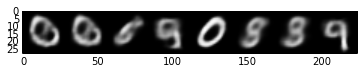

In [4]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import datetime as dt


img = np.column_stack([decoder_model.forward(np.random.randn(1,2)).reshape(28,28) for s in range(8)])
imshow(img, cmap='gray')


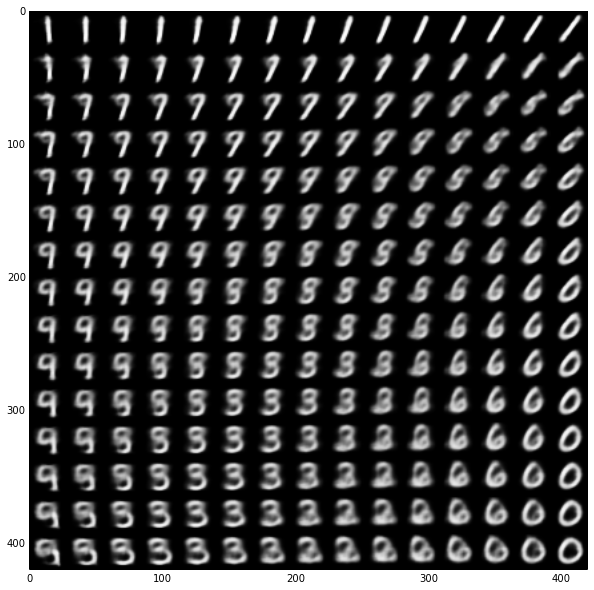

In [5]:
# This code snippet references this keras example (https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_model.forward(z_sample)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()